In [1]:
######################################### Import statements ###########################################

import sys
sys.path.append("..")   # this allows us to import from sibling directory

from code_to_import.Graph_Dataset_Preprocessing import GraphProductionModeDataset

import argparse
import os
import numpy as np
import math

from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F   # NOTE: I don't think this is used
import torch.autograd as autograd
import torch

from matplotlib import pyplot as plt
from IPython import display


print(torch.cuda.is_available())
import dgl
import dgl.data
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.nn import GraphConv




Using backend: pytorch


['gen_l_eta', 'gen_lbar_eta', 'gen_l_phi', 'gen_lbar_phi', 'gen_l_pt', 'gen_lbar_pt', 'gen_l_mass', 'gen_lbar_mass', 'gen_nu_eta', 'gen_nubar_eta', 'gen_nu_phi', 'gen_nubar_phi', 'gen_nu_pt', 'gen_nubar_pt', 'gen_nu_mass', 'gen_nubar_mass', 'gen_b_eta', 'gen_bbar_eta', 'gen_b_phi', 'gen_bbar_phi', 'gen_b_pt', 'gen_bbar_pt', 'gen_b_mass', 'gen_bbar_mass', 'gen_top_eta', 'gen_tbar_eta', 'gen_top_phi', 'gen_tbar_phi', 'gen_top_pt', 'gen_tbar_pt', 'gen_top_mass', 'gen_tbar_mass', 'gen_wplus_eta', 'gen_wminus_eta', 'gen_wplus_phi', 'gen_wminus_phi', 'gen_wplus_pt', 'gen_wminus_pt', 'gen_wminus_mass', 'gen_wplus_mass', 'production_mode', 'eventWeight', '__index__']
num qqbar = 52908
4.0
training torch.Size([84652, 10, 4])
evaluating torch.Size([21163, 10, 4])
False


In [3]:
""" 
Configure everything here
"""

class args():
    channel = "ee"
    cut = -1
    version = -1
    cut_version = -1
    weight = "true"
    drop = 0.2
    input = "allorentz_gen"
    includes_qg = "false"
    dir_names = "GNN"

In [4]:
######################## THIS CLASS INCLUDES ALL THE VARIABLES YOU WANT TO CONFIGURE #################################
#######################################################################################################################

class opt():   # Class used for optimizers in the future. Defines all variables and stuff needed.
#     save_weights = True  # Tells whether to save weights... currently not used
    
    load_model = False  # set true if you want to load and continue training a previous model
    
    draw = True # set to false when running on slurm
    
    n_epochs = 40000   # an epoch is the number of times it works through the entire training set.
                       # This sets the total number of epochs which will be run
    
    batch_size = 2000  # the training set is broken up into batches, 
                        # this sets the size of each batch
    
    # this is the number of outputs for the neural network
    output_num = 3
    if args.includes_qg != "true":
        output_num = 2
    
    lr = 0.0001   # learning rate (how much to change based on error)
    b1 = 0.9   # Used for Adam. Exponential decay rate for the first moment
    b2 = 0.999   # Used for Adam. Exponential decay rate for the second moment estimates (gradient squared)
        
    correlation_cut = args.cut   # this is the correlation cut... If negative then no cut is applied
    
    drop = args.drop   # percentage of nodes which will be dropped each time
    
    weight_cmd = args.weight   # could also be "false" and "no-neg".
                          # This determines whether weights and negative weights are used
    
    qg_cmd = (args.includes_qg == "true")   # this is a boolean which determines if qg is included (true) or excluded (false)
    
    # the root_path leads to the folder with the root files being used for data
    root_path = "/depot/cms/top/mcnama20/TopSpinCorr-Run2-Entanglement/CMSSW_10_2_22/src/TopAnalysis/Configuration/analysis/diLeptonic/three_files/Nominal"
    
    # this is the data root file loaded into the dataloader
    file = root_path + "/" + args.channel
    if args.input == "all":
        file += "_modified_root_1.root"   
    elif args.input == "lorentz":
        file += "_modified_root_1_lorentzvectors.root"
    elif args.input == "spinCorr":
        file +="_modified_root_1_spinCorr.root"
    elif args.input == "lorentzdelta":
        file += "_modified_root_1_lorentzvectorsdelta.root"
    #elif args.input == "lorentzgen":
     #   file += "_modified_root_1_lorentzvectorsdelta_gen.root"
    elif args.input == "lorentz_mttbar":
        file += "_modified_root_1_lorentzvectors_mttbar_mass.root"
    elif args.input == "lorentz_delta2":
        file += "__modified_root_1_lorentzvectorsdelta_version2.root"
    elif args.input == "lorentzdelta_gen":
        file += "_modified_root_1_lorentzvectorsdelta_gen.root"
    elif args.input == "allorentz_gen":
        file += "_modified_root_1_allorentz_gen.root"
    
    # this is the model name. Change it when running a new model
    model_name = "GNN_Model4Layers_V1_" + args.channel  + "_weights_" + weight_cmd
    
    # add version information if included
    if args.version > 0:
        model_name += str(args.version)
                    
    # add cut version to model name if included in args
    if args.cut_version > 0:
        model_name += "cutV" + str(args.cut_version)
        
    # add input type. Can be "all", "lorentz" and "spinCorr"
    if args.input != "all":
        model_name += "_" + args.input
        
    if not qg_cmd:
        model_name += "_no_qg"
    
    
    print(model_name)
    
    # load data object so we can access validation and training data    
    if correlation_cut > 0:
        data = GraphProductionModeDataset(file, correlation_cut=correlation_cut, cut_version=args.cut_version, include_qg = qg_cmd)
    else:
        data = GraphProductionModeDataset(file, include_qg = qg_cmd)
        
    model_name += "batch" + str(batch_size)
        

print("The model in this run is " + opt.model_name)   # this will make slurm output easier to identify


cuda = True if torch.cuda.is_available() else False


GNN_Model4Layers_V1_ee_corrCut_-1_weights_true_drop_0.2_allorentz_gen_no_qg
['gen_l_eta', 'gen_lbar_eta', 'gen_l_phi', 'gen_lbar_phi', 'gen_l_pt', 'gen_lbar_pt', 'gen_l_mass', 'gen_lbar_mass', 'gen_nu_eta', 'gen_nubar_eta', 'gen_nu_phi', 'gen_nubar_phi', 'gen_nu_pt', 'gen_nubar_pt', 'gen_nu_mass', 'gen_nubar_mass', 'gen_b_eta', 'gen_bbar_eta', 'gen_b_phi', 'gen_bbar_phi', 'gen_b_pt', 'gen_bbar_pt', 'gen_b_mass', 'gen_bbar_mass', 'gen_top_eta', 'gen_tbar_eta', 'gen_top_phi', 'gen_tbar_phi', 'gen_top_pt', 'gen_tbar_pt', 'gen_top_mass', 'gen_tbar_mass', 'gen_wplus_eta', 'gen_wminus_eta', 'gen_wplus_phi', 'gen_wminus_phi', 'gen_wplus_pt', 'gen_wminus_pt', 'gen_wminus_mass', 'gen_wplus_mass', 'production_mode', 'eventWeight', '__index__']
num qqbar = 52908
4.0
training torch.Size([84652, 10, 4])
evaluating torch.Size([21163, 10, 4])
The model in this run is GNN_Model4Layers_V1_ee_corrCut_-1_weights_true_drop_0.2_allorentz_gen_no_qgbatch2000


In [5]:
###################### Now save training and validation sets for future analysis ###################################
np.save("../data/GNN/train_val_datasets/training_dataset_" + opt.model_name + ".npy", opt.data.get_training_data())
np.save("../data/GNN/train_val_datasets/validation_dataset_" + opt.model_name + ".npy", opt.data.get_eval_data())


# In[29]:

/home/mcnama20/.conda/envs/cent7/5.1.0-py36/GANS_7/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [6]:
# build up version
        up_source = torch.tensor([6, 7, 8, 9, 2, 3, 4, 5])
        up_range =  torch.tensor([3, 3, 4, 4, 0, 0, 1, 1])
        
        # build down version
        down_source = torch.tensor([3, 3, 4, 4,  0, 0, 1, 1])
        down_range = torch.tensor([6, 7, 8, 9, 2, 3, 4, 5])
        
        # similar type connection
        sim_source = torch.tensor([6, 8, 7, 9, 2, 5, 3, 4, 0, 1])
        sim_range = torch.tensor([8, 6, 9, 7, 5, 2, 4, 3, 1, 0])
        
        # same parent
        child_source = torch.tensor([6, 7, 8, 9, 2, 3, 4, 5])
        child_range = torch.tensor([7, 6, 9, 8, 3, 2, 5, 4])
        
        ############### for now I will include building up and both similar and same parent TODO: add parameter to determine
        # this
        source_ids = torch.cat((up_source, sim_source, child_source))
        range_ids = torch.cat((up_range, sim_range, child_range))
        graph = dgl.graph((source_ids, range_ids), num_nodes=10)
        graph = dgl.add_self_loop(graph)


In [7]:
graph

Graph(num_nodes=10, num_edges=36,
      ndata_schemes={}
      edata_schemes={})

In [8]:
batched_graphs = graph

for i in range(opt.batch_size - 1):
    batched_graphs = dgl.batch([batched_graphs, graph])

In [9]:
# batched_graphs = graph
# for i in range(7):
#     batched_graphs =dgl.batch([batched_graphs, batched_graphs])

In [10]:
batched_graphs

Graph(num_nodes=20000, num_edges=72000,
      ndata_schemes={}
      edata_schemes={})

In [11]:
opt.data.__getitem__(0)

(tensor([[3.8235e-01, 5.0006e-01, 1.0847e-01, 1.7250e+02],
         [3.5852e-01, 7.7079e-01, 6.4876e-02, 1.7250e+02],
         [3.5649e-01, 5.0298e-01, 1.0222e-01, 6.0678e-01],
         [5.5413e-01, 4.9402e-01, 4.1555e-02, 4.8512e-01],
         [3.3636e-01, 5.9707e-01, 4.1467e-02, 4.8534e-01],
         [3.2623e-01, 8.7314e-01, 7.8170e-02, 6.5261e-01],
         [3.6887e-01, 4.4456e-01, 6.7445e-02, 5.0103e-01],
         [5.6041e-01, 8.3116e-01, 2.5951e-02, 6.1560e-01],
         [3.4764e-01, 1.1157e-01, 2.4654e-02, 5.6265e-01],
         [3.4763e-01, 6.0227e-01, 9.2736e-02, 5.4214e-01]]),
 0.0,
 0.8690045295014476)

In [12]:
############################## Configure data loader depending on if there is a correlation cut ###########################
if opt.correlation_cut > 0:
    os.makedirs("../data/" + args.dir_names + "/", exist_ok=True)
    dataloader = torch.utils.data.DataLoader(
        opt.data,
        batch_size=opt.batch_size, drop_last=True,
        shuffle=True
    )
else:
    os.makedirs("../data/" + args.dir_names + "/", exist_ok=True)
    dataloader = torch.utils.data.DataLoader(
        opt.data,
        batch_size=opt.batch_size, drop_last=True,
        shuffle=True
    )
print('done')

data = iter(dataloader)
x = data.next()
input_size = x[0].shape[1] -3


done


In [14]:
####################################### load data for evaluation of model (not training set) and separate weights and target
validation_data = opt.data.get_eval_data()

w_val = validation_data[2]
target_val = validation_data[1]
target_val = Variable(torch.from_numpy(target_val).type(torch.LongTensor))
y_val = validation_data[0]
val_data = torch.reshape(y_val, (10 * y_val.shape[0], 4))
                    
# replace all negative weighted events with zero if the weight_cmd says to
if opt.weight_cmd == "no-neg":
    w_val[w_val < 0] = 0

# remove weighting (aka, set all to 1) if weight_cmd says to
if opt.weight_cmd == "false":
    w_val = np.ones(w_val.shape)
    
w_val = Variable(torch.from_numpy(w_val).type(torch.FloatTensor))




In [15]:
val_graphs = graph

for i in range(y_val.shape[0] - 1):
    val_graphs = dgl.batch([val_graphs, graph])

In [16]:

class GCN(nn.Module):
    def __init__(self, in_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, 128)
        self.conv2 = GraphConv(128, 64)
        self.conv3 = GraphConv(64, 32)
        self.conv4 = GraphConv(32, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = 
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g,h)
        h = F.relu(h)
        h = self.conv4(g,h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [17]:
criterion = nn.CrossEntropyLoss()# this is the loss function. reduction='none' makes it return a value for each input (reduce=False was deprecated)


In [18]:
model = GCN(4, 2)

In [19]:
batched_graphs

Graph(num_nodes=20000, num_edges=72000,
      ndata_schemes={}
      edata_schemes={})

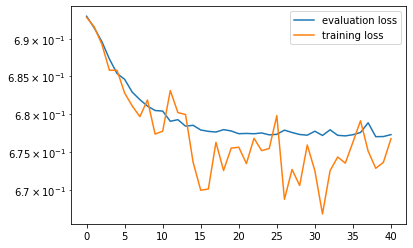

loss = tensor(0.6763, grad_fn=<NllLossBackward>)


KeyboardInterrupt: 

In [20]:
# Create the model with given dimensions

small_loss = 1e20   # This is the initail loss under which we overwrite the model.
                    # initialize with a large loss so everything is smaller than it

# initialize loss arrays
loss_val_array = np.array(())
loss_array = np.array(())
lva = 0  # this is the length of the loaded array
la = 0  # this is the length of the other loaded array
optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
loss_array = np.array(())
validation_arry = np.array(())
small_loss = 1e20   # This is the initail loss under which we overwrite the model.


for epoch in range(opt.n_epochs):
    count = 0
    for batched_data, labels, weights in dataloader:
        count += count
        init_batch = batched_data
#         print(init_batch)
#         print(batched_data.shape)
        batched_data = torch.reshape(batched_data, (10 * opt.batch_size, 4))
#         batched_data = batched_data[0]
        pred = model(batched_graphs, batched_data)
#         print("prediction is " + str(pred[0].dtype))
#         target = np.zeros((2,1))
#         target[0] = 1-labels
#         target[1] = labels
#         labels = target.astype(int)
#         labels = np.transpose(labels)

#         labels = torch.from_numpy(labels)
        labels = Variable(labels.type(torch.LongTensor))
#         print("labels are \n" + str(labels))
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#     if epoch % 5 == 0:
# if count%1000 == 0:
    #----------------------------------
    # Draw training and validation loss
    #-------------------------------------
    print("loss = " + str(loss))
    if epoch %5 == 0:
        loss_array = np.append(loss_array, loss.detach().numpy()) # append the training loss to the loss array
        out = model(val_graphs, val_data)   # run classifier on validation data to see how good it is
        loss_val = criterion(out, target_val)# calculate the validation loss
        loss_val_array = np.append(loss_val_array, loss_val.detach().numpy()) # append the validation loss to its array


        if small_loss > loss_val:   # compare to see if the loss has decreased
            small_loss = loss_val   # if the network has improved replace the best loss with this one
            torch.save(model.state_dict(), "../models/GNN/" + opt.model_name + ".pt")   # save the new (and better) model
            torch.save(optimizer.state_dict(), "../models/GNN/optimizer_" + opt.model_name + ".pt") # save the optimizer state


        np.save("../data/GNN/" + opt.model_name +  "_loss_val_array.npy",loss_val_array)
        np.save("../data/GNN/" + opt.model_name + "_loss_train_array.npy",loss_array)
        display.clear_output(True)
        figure = plt.figure()
        ax = figure.add_subplot(111)
        ax.set_yscale("log")
        ax.plot(loss_val_array, label = "evaluation loss")
        ax.plot(loss_array, label="training loss")
        plt.legend()
        plt.show()
        

